In [1]:
import models
from models import model, create_cd_cluster, cd_diagram, bt_plot,glrt, ci_plot
from dataset_management import get_dataset, convert_to_autorank
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

algorithm="algorithm";benchmark="bench_prior";seed="seed";budget="used_fidelity";loss="value"
data=get_dataset(dataset_name="fig5_full")

✅ Loading data done                                                                                 


In [10]:

loss="normalized_regret"
wins_zone_x_bench=pd.DataFrame()
wins_bench=pd.DataFrame()
budget_zones=[[1,6],[6,12],[12,18],[18,24]]
ds=data.loc[data[algorithm].isin(["PB","HB"])] #PB, HB
ds=ds.loc[(ds[budget].isin(range(1,25)))&(ds["prior"].isin(["at25","bad"]))]
wins_zone_x_bench[benchmark]=list(ds[benchmark].unique())

full_wins=[]
full_scores=[]
full_benchmarks=[]
full_zones=[]
full_fidelities=[]
for f_n,f in enumerate(ds[budget].unique()):
    print(f"{f:<11} ({f_n+1}/{len(ds[budget].unique())})",end="\r",flush=True)
    wins_budget=[]
    for bench in ds[benchmark].unique():
        if len(ds.loc[(ds[budget]==f)&(ds[benchmark]==bench)])==0:
            continue
        full_fidelities.append(f)
        mod=model(f"{loss}~{algorithm}",ds.loc[(ds[budget]==f)&(ds[benchmark]==bench)],algorithm)
        post_hocs=mod.post_hoc(algorithm)
        if post_hocs[1].Sig[0] in ["***","**","*"]:
            wins_budget.append(-1 if post_hocs[1].Contrast[0].rsplit(" - ")[0 if post_hocs[1].Estimate[0]<0 else 1]=="HB" else 1)
            full_wins.append(-1 if post_hocs[1].Contrast[0].rsplit(" - ")[0 if post_hocs[1].Estimate[0]<0 else 1]=="HB" else 1)
            full_scores.append(post_hocs[1].Estimate[0])
        else:
            wins_budget.append(0) 
            full_wins.append(0)
            full_scores.append(0)
        full_benchmarks.append(bench)
        if f==24:
            full_zones.append(f"{budget_zones[-1][0]}_{budget_zones[-1][1]}")
        for zone in budget_zones:
            if f>=zone[0] and f<zone[1]:
                full_zones.append(f"{zone[0]}_{zone[1]}")  


In [2]:
# wins_bench[benchmark]=full_benchmarks
# wins_bench["wins"]=full_wins
# wins_bench["scores"]=full_scores
# wins_bench["fidelity"]=full_fidelities
# wins_bench["zone"]=full_zones
# wins_bench["wins"]=wins_bench["wins"].astype(float)
# wins_bench["zone"]=wins_bench["zone"].astype(str)
# def split_benchmark_prior(row):
#     return pd.Series(row[benchmark].rsplit("_",1))
# wins_bench[["benchmark","prior"]]=wins_bench.apply(split_benchmark_prior,axis=1)
# print(wins_bench)
# wins_bench.to_parquet("datasets/benchmark_clust_at25bad_int.parquet")

In [7]:
wins_bench=pd.read_parquet("datasets/benchmark_clust_at25bad_int_anon_prior.parquet")
wins_bench=wins_bench.loc[wins_bench["prior"].isin(["at25","bad"])]
wins_bench["bench_prior"]=wins_bench.apply(lambda row: row['benchmark']+'_'+'X' if row['prior']=="bad" else row['benchmark']+'_'+'Y',axis=1)
print(wins_bench)

    bench_prior  wins  scores  fidelity   zone benchmark prior
0         B-0_X  -1.0   0.752       1.0    1_6       B-0   bad
1         B-1_X  -1.0   0.782       1.0    1_6       B-1   bad
2         B-2_X  -1.0   0.608       1.0    1_6       B-2   bad
3         B-3_X  -1.0   0.770       1.0    1_6       B-3   bad
4         B-4_X  -1.0   0.793       1.0    1_6       B-4   bad
5         B-5_X  -1.0   0.682       1.0    1_6       B-5   bad
6         B-6_X  -1.0   0.714       1.0    1_6       B-6   bad
7         B-7_X  -1.0   0.819       1.0    1_6       B-7   bad
8         B-8_X  -1.0   0.536       1.0    1_6       B-8   bad
9         B-9_X  -1.0   0.650       1.0    1_6       B-9   bad
10       B-10_X  -1.0   0.929       1.0    1_6      B-10   bad
11       B-11_X  -1.0   0.670       1.0    1_6      B-11   bad
12        B-6_Y   1.0  -0.290       1.0    1_6       B-6  at25
13        B-8_Y   1.0  -0.415       1.0    1_6       B-8  at25
14       B-11_Y   1.0  -0.308       1.0    1_6      B-1

P-values adjusted by tukey method for family of 276 estimates


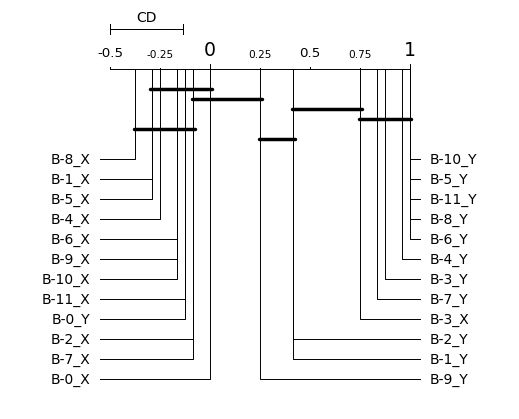

In [10]:
# wins_bench=pd.read_parquet("datasets/benchmark_clust_at25bad_int_anon_prior.parquet")
# wins_bench=wins_bench.loc[wins_bench["prior"].isin(["at25","bad"])]
wins_bench[benchmark]=wins_bench[benchmark].astype(str)
# wins_bench.to_csv("wins_bench.csv")
# 1(|benchmark) changes nothing
wins_model=model(f"wins~bench_prior+fidelity",wins_bench,benchmark)
fig=plt.figure(cd_diagram(wins_model.post_hoc(benchmark),False,5,system_id=benchmark,split_labels=False))
plt.savefig(dpi=300,pad_inches=0.1, bbox_inches="tight",fname="img/bench_clust_at25bad_int_fid_anon_XY.png")
# wins_model=model(f"wins~{benchmark}+(1|benchmark)",wins_bench,benchmark)
# cd_diagram(wins_model.post_hoc(benchmark),False,5,system_id=benchmark)


In [30]:
wins_bench=pd.read_parquet("datasets/benchmark_clust_at25bad_int.parquet")
wins_bench=wins_bench.loc[wins_bench["prior"].isin(["at25","bad"])]
wins_bench[benchmark]=wins_bench[benchmark].astype(str)
wins_model=model(f"wins~bench_prior+fidelity",wins_bench,benchmark)
contrasts=wins_model.post_hoc(benchmark)[1]


P-values adjusted by tukey method for family of 276 estimates


In [81]:
contrasts[["benchmark1","benchmark2"]]=contrasts["Contrast"].str[1:-1].str.split(' - ',expand=True)
contrasts["benchmark1"]=contrasts["benchmark1"].str[:-1]
contrasts["benchmark2"]=contrasts["benchmark2"].str[1:]
# print(contrasts)
# print(contrasts["benchmark1"].str[:-4])
# print(contrasts["benchmark2"].str[:-4])
print(contrasts.loc[contrasts["benchmark1"].str[:-3]==contrasts["benchmark2"].str[:-4]][["Contrast","Estimate","P-val","Sig"]])


                                     Contrast  Estimate  P-val  Sig
16         (LC-167190_bad) - (LC-167190_at25)     0.125  1.000     
37         (LC-126026_bad) - (LC-126026_at25)    -0.708  0.000  ***
66         (LC-168330_bad) - (LC-168330_at25)    -0.500  0.000  ***
83         (LC-168910_bad) - (LC-168910_at25)    -0.125  1.000     
103          (PD1-LM1B_bad) - (PD1-LM1B_at25)    -1.208  0.000  ***
118            (PD1-WMT_bad) - (PD1-WMT_at25)    -1.292  0.000  ***
129          (JAHS-C10_bad) - (JAHS-C10_at25)    -1.167  0.000  ***
155        (LC-189906_bad) - (LC-189906_at25)    -0.917  0.000  ***
161  (PD1-Cifar100_bad) - (PD1-Cifar100_at25)    -1.375  0.000  ***
179            (JAHS-CH_bad) - (JAHS-CH_at25)    -0.417  0.007   **
194            (JAHS-FM_bad) - (JAHS-FM_at25)    -1.167  0.000  ***
201  (PD1-ImageNet_bad) - (PD1-ImageNet_at25)    -1.125  0.000  ***
